### Libraries

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
from Bio import AlignIO
from Bio.Align import substitution_matrices
from Bio.Data import IUPACData
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

'''import cafaeval
from cafaeval.evaluation import cafa_eval
from cafaeval.parser import obo_parser, gt_parser'''

from pathlib import Path
import os

import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Creating the path to the main folder we are going to use to create our datasets

In [4]:
# Path to train data
training_data_path = Path('../data/train')

# Path to test data
test_data_path = Path('../data/test')

# Path to baseline data
baseline_data_path = Path('../data/baseline')


# Training Set

In this section we are **creating the Training Set**, fusing togheter the data from:
- _train_set.tsv_
- _train_ids.txt_
- _train.fasta_
- _train_embeddings.h5_
- _train_protein2ipr.dat_
- _go-basic.obo_

### Extracting `train_set.tsv`

In [5]:
train_set = pd.read_csv(training_data_path / 'train_set.tsv', sep='\t')

# Rename Protein_ID and aspect columns
train_set.rename(columns={'Protein_ID': 'ID', 'aspect' : 'sub_ontology'}, inplace=True)

# Display the first few rows of the train set
train_set.head()

,ID,sub_ontology,GO_term
0,P91124,cellular_component,GO:0005575
1,P91124,cellular_component,GO:0110165
2,P91124,cellular_component,GO:0005737
3,P91124,cellular_component,GO:0005622
4,P91124,cellular_component,GO:0043226


### Extracting `train_ids.txt`

In [6]:
# Extracting train_ids.txt
with open(training_data_path / 'train_ids.txt', 'r') as file:
    train_ids = file.read().splitlines()

# Display the first few IDs to verify
print(train_ids[:5])

['P91124', 'Q55DL5', 'O81027', 'Q04418', 'Q8IXT2']


In [7]:
if len(train_ids) == len(train_set['ID'].unique()):
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(train_ids)}).\n"
          "Proceeding with the analysis.")

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (123969).
Proceeding with the analysis.


### Extracting `train.fasta`

In [8]:
train_fasta_list = list(SeqIO.parse(training_data_path / 'train.fasta', 'fasta'))

# Print the first sequence to verify
print(train_fasta_list[0])

ID: P91124
Name: P91124
Description: P91124
Number of features: 0
Seq('MAAQFYERNTSGMNADRFMTRLTDESTVNTMQRHYWTARQFIRTKLGKKEDEHL...NLL')


Let's transform it into a DataFrame

In [9]:
# Extract relevant information from SeqRecord
train_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in train_fasta_list]

# Create a DataFrame from the extracted data
train_fasta = pd.DataFrame(train_fasta_dict)

# Display the DataFrame
train_fasta.head()

,ID,name,description,num_features,sequence
0,P91124,P91124,P91124,0,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,Q55DL5,Q55DL5,0,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,O81027,O81027,0,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,Q04418,Q04418,0,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,Q8IXT2,Q8IXT2,0,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


Checking if `ID`, `name` and `description` have the same information

In [10]:
# Checking for differences between the ID and name columns
diff_id_name = sum(train_fasta['ID'] != train_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(train_fasta['ID'] != train_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


Checking if `num_features` has value different from 0

In [11]:
num_features_values = sum(train_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


**Nice!**

We found that `ID`, `name` and `description` columns are the same. We can remove two of them (`name`, `descritpion`). 

In the same way we saw that `num_features` is not very informative since it has only 0, let's remove it as well



In [12]:
train_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


train_fasta.head()

,ID,sequence
0,P91124,"(M, A, A, Q, F, Y, E, R, N, T, S, G, M, N, A, ..."
1,Q55DL5,"(M, S, E, I, L, I, D, S, E, L, L, S, C, P, I, ..."
2,O81027,"(M, Q, W, N, G, V, R, R, A, H, S, I, W, C, K, ..."
3,Q04418,"(M, D, L, L, G, D, I, V, E, K, D, T, S, D, S, ..."
4,Q8IXT2,"(M, E, P, S, D, M, P, A, G, Y, H, C, P, L, D, ..."


### Extracting `train_embeddings.h5`

In [13]:
filename = "train_embeddings.h5"

data_list = []

with h5py.File(training_data_path / filename, "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

train_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

train_embeddings.head()

,ID,embeddings
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376..."
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243..."
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788..."
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335..."
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,..."


### Extracting `train_protein2ipr.dat`

In [14]:
train_protein2ipr = pd.read_csv(training_data_path / 'train_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
train_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Display the first few rows of the train set
train_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,PS50104,133,266
1,A0A009IHW8,IPR000157,Toll/interleukin-1 receptor homology (TIR) domain,SM00255,134,258
2,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,G3DSA:3.40.50.10140,80,266
3,A0A009IHW8,IPR035897,Toll/interleukin-1 receptor homology (TIR) dom...,SSF52200,128,249
4,A0A021WW32,IPR006910,"Rad21/Rec8-like protein, N-terminal",PF04825,1,103


In [15]:
# Group by 'ID' and aggregate other columns into lists
train_protein2ipr_grouped = train_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Train protein2ipr ({train_protein2ipr.shape}):")
train_protein2ipr_grouped.head()

Train protein2ipr ((1103545, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A009IHW8,"(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW7,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"
4,A0A023FDY8,"(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


Still have to understand what *tizio, caio, sempronio* are.

### Extracting `go-basic.obo`

In [16]:
import re

file_path = "../data/train/go-basic.obo"  # Replace with your file path

# Step 1: Initialize storage for GO terms
go_terms = []

# Step 2: Parse the .obo file
with open(file_path, 'r') as file:
    current_term = {}
    for line in file:
        line = line.strip()
        
        # Start of a new term
        if line == "[Term]":
            if current_term:  # Save the previous term
                go_terms.append(current_term)
            current_term = {}  # Start a new term
            
        elif line.startswith("id:"):
            current_term['ID'] = line.split("id: ")[1]
            
        elif line.startswith("alt_id:"):
            alt_id = line.split("alt_id: ")[1]
            current_term.setdefault('alt_ids', []).append(alt_id)
            
        elif line.startswith("name:"):
            current_term['name'] = line.split("name: ")[1]
            
        elif line.startswith("namespace:"):
            current_term['namespace'] = line.split("namespace: ")[1]
            
        elif line.startswith("is_a"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                is_a_id = match.group()
                current_term.setdefault('is_a', []).append(is_a_id)
                
        elif line.startswith("relationship: part_of"):
            match = re.search(r"GO:\d+", line)  # Search for GO ID
            if match:  # Check if a match was found
                part_of_id = match.group()
                current_term.setdefault('part_of', []).append(part_of_id)

            
    # Add the last term
    if current_term:
        go_terms.append(current_term)

# Step 3: Create a unified list of all IDs (primary and alt_ids)
expanded_terms = []
for term in go_terms:
    primary_id = term['ID']
    alt_ids = term.get('alt_ids', [])
    all_ids = [primary_id] + alt_ids
    
    for term_id in all_ids:
        expanded_terms.append({
            'ID': term_id,
            'name': term.get('name'),
            'namespace': term.get('namespace'),
            'is_a': term.get('is_a', []),
            'part_of': term.get('part_of', [])
        })

# Step 4: Convert to a DataFrame
df = pd.DataFrame(expanded_terms)

# Step 5: Filter by namespace and explode relationships
df_is_a = df.explode('is_a').dropna(subset=['is_a'])
df_part_of = df.explode('part_of').dropna(subset=['part_of'])


print("All IDs with namespaces:")
df.head()

All IDs with namespaces:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,"[GO:0048308, GO:0048311]",[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,[GO:0007005],[]
2,GO:0000003,reproduction,biological_process,[GO:0008150],[]
3,GO:0019952,reproduction,biological_process,[GO:0008150],[]
4,GO:0050876,reproduction,biological_process,[GO:0008150],[]


In [17]:
print("'is_a' relationships:")
df_is_a.head()

'is_a' relationships:


,ID,name,namespace,is_a,part_of
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048308,[]
0,GO:0000001,mitochondrion inheritance,biological_process,GO:0048311,[]
1,GO:0000002,mitochondrial genome maintenance,biological_process,GO:0007005,[]
2,GO:0000003,reproduction,biological_process,GO:0008150,[]
3,GO:0019952,reproduction,biological_process,GO:0008150,[]


In [18]:
print("'part_of' relationships:")
df_part_of.head()

'part_of' relationships:


,ID,name,namespace,is_a,part_of
16,GO:0000015,phosphopyruvate hydratase complex,cellular_component,[GO:1902494],GO:0005829
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
22,GO:0000022,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0000070
23,GO:1905121,mitotic spindle elongation,biological_process,"[GO:0051231, GO:1903047]",GO:0007052


## Merging all previous extractions

Let us collect the dataframes and check lengths. Noting that:
- _train_set.tsv_ contains the proteins, their GO annotations and their corresponding aspects which will be used to subdivde it into three separate datasets
- _train.fasta_ and _train_embeddings.h5_ can be grouped together since they refers to the whole input
- _train_protein2ipr.dat_
- _go-basic.obo_

In [19]:
def group_and_combine(df, sub_ontology_value):
    return df[df['sub_ontology'] == sub_ontology_value].groupby('ID')['GO_term'].apply(tuple).reset_index()

# Create three dataframes for each sub_ontology value
df_CC = group_and_combine(train_set, 'cellular_component')
df_MF = group_and_combine(train_set, 'molecular_function')
df_BP = group_and_combine(train_set, 'biological_process')

print(f"Shapes: CC {df_CC.shape}, MF {df_MF.shape}, BP {df_BP.shape}")

print(f"Cellular Component ({df_CC.shape[0]}):")
df_CC.head()

Shapes: CC (84638, 2), MF (55698, 2), BP (83064, 2)
Cellular Component (84638):


,ID,GO_term
0,A0A021WW32,"(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [20]:
combined_train = pd.merge(train_embeddings, train_fasta, on='ID')
combined_train = pd.merge(combined_train, train_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_train[combined_train['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

# combined_train = combined_train.drop('domain', axis=1)

print(f"Combined DataFrame shape: {combined_train.shape}")
combined_train.head()

Number of rows missing from train_protein2ipr_grouped: 6522
Combined DataFrame shape: (123969, 8)


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A009IHW8,"[0.0682, -0.04648, 0.001752, -0.00858, 0.00376...","(M, S, L, E, Q, K, K, G, A, D, I, I, S, K, I, ...","(IPR000157, IPR000157, IPR035897, IPR035897)",(Toll/interleukin-1 receptor homology (TIR) do...,"(PS50104, SM00255, G3DSA:3.40.50.10140, SSF52200)","(133, 134, 80, 128)","(266, 258, 266, 249)"
1,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
2,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
3,A0A023FBW4,"[0.002447, 0.007053, 0.06445, 0.00727, -0.0335...","(M, T, S, H, G, A, V, K, I, A, I, F, A, V, I, ...",NaN,NaN,NaN,NaN,NaN
4,A0A023FBW7,"[0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...","(M, K, V, L, L, Y, I, A, A, S, C, L, M, L, L, ...","(IPR045797,)","(Evasins Class A,)","(PF19429,)","(38,)","(110,)"


In [21]:
# Merge combined_train with df_ab
df_CC_full= pd.merge(combined_train, df_CC, on='ID', how='right')
df_MF_full= pd.merge(combined_train, df_MF, on='ID', how='right')
df_BP_full= pd.merge(combined_train, df_BP, on='ID', how='right')

print(f"Shapes: CC {df_CC_full.shape}, MF {df_MF_full.shape}, BP {df_BP_full.shape}")

print(f"Full df CC {df_CC_full.shape}:")
df_CC_full.head()

Shapes: CC (84638, 9), MF (55698, 9), BP (83064, 9)
Full df CC (84638, 9):


,ID,embeddings,sequence,ipr,domain,familyID,start,end,GO_term
0,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)","(GO:0005575, GO:0110165, GO:0000785, GO:003299..."
1,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)","(GO:0005575, GO:0110165, GO:0071944, GO:000588..."
2,A0A023GPJ3,"[0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...","(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100...","(GO:0005575, GO:0110165, GO:0005622, GO:000582..."
3,A0A023GUT0,"[-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...","(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)","(GO:0005575, GO:0110165, GO:0005576, GO:0005615)"
4,A0A023IM54,"[-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...","(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3...","(GO:0005575, GO:0005737, GO:0042175, GO:003299..."


In [22]:
x_df_CC = df_CC_full.iloc[:, :-1]
y_df_CC = df_CC_full.iloc[:, -1]
x_df_MF = df_MF_full.iloc[:, :-1]
y_df_MF = df_MF_full.iloc[:, -1]
x_df_BP = df_BP_full.iloc[:, :-1]
y_df_BP = df_BP_full.iloc[:, -1]

print(f"Shapes: x_df_CC {x_df_CC.shape}, y_df_CC {y_df_CC.shape}, x_df_MF {x_df_MF.shape}, y_df_MF {y_df_MF.shape}, x_df_BP {x_df_BP.shape}, y_df_BP {y_df_BP.shape}")

print("CC Input:")
x_df_CC.head()

Shapes: x_df_CC (84638, 8), y_df_CC (84638,), x_df_MF (55698, 8), y_df_MF (55698,), x_df_BP (83064, 8), y_df_BP (83064,)
CC Input:


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A021WW32,"[-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...","(M, F, Y, E, H, I, I, L, A, K, K, G, P, L, A, ...","(IPR006910, IPR039781, IPR049589)","(Rad21/Rec8-like protein, N-terminal, Rad21/Re...","(PF04825, PTHR12585, cd21792)","(1, 1, 327)","(103, 607, 404)"
1,A0A021WZA4,"[0.007904, 0.0877, -0.001715, 0.03766, 0.01788...","(M, K, Y, I, N, C, T, Q, P, A, I, D, D, F, P, ...","(IPR004481, IPR004481, IPR004837, IPR004837, I...","(Sodium/potassium/calcium exchanger, Sodium/po...","(PTHR10846, TIGR00367, PF01699, PF01699, G3DSA...","(6, 31, 33, 329, 64, 286)","(496, 476, 175, 480, 258, 482)"
2,A0A023GPJ3,"[0.01512, 0.01102, 0.0217, -0.02512, 0.0396, 0...","(M, D, R, D, A, E, E, G, R, P, L, S, L, V, N, ...","(IPR013087, IPR013087, IPR013087, IPR013087, I...","(Zinc finger C2H2-type, Zinc finger C2H2-type,...","(PF00096, PF00096, PF00096, PF00096, PS00028, ...","(644, 956, 983, 1013, 197, 646, 674, 957, 985,...","(666, 977, 1005, 1034, 218, 666, 694, 977, 100..."
3,A0A023GUT0,"[-0.00414, -0.01288, 0.0716, 0.01605, -0.03983...","(M, R, C, P, G, V, S, L, W, G, L, L, C, L, G, ...","(IPR000065, IPR000065, IPR009079, IPR009079)","(Leptin, Leptin, Four-helical cytokine-like, c...","(PF02024, PTHR11724, G3DSA:1.20.1250.10, SSF47...","(28, 7, 24, 29)","(172, 172, 172, 172)"
4,A0A023IM54,"[-0.01651, 0.02525, 0.04333, 0.01558, -0.01678...","(M, K, L, L, P, L, L, V, V, V, A, L, G, L, A, ...","(IPR003006, IPR003597, IPR003597, IPR007110, I...",(Immunoglobulin/major histocompatibility compl...,"(PS00290, PF07654, SM00407, PS50835, PR01669, ...","(382, 312, 312, 294, 55, 135, 199, 247, 271, 3...","(388, 391, 394, 401, 63, 146, 216, 261, 287, 3..."


In [23]:
print("CC Target:")
y_df_CC.head()

CC Target:


0    (GO:0005575, GO:0110165, GO:0000785, GO:003299...
1    (GO:0005575, GO:0110165, GO:0071944, GO:000588...
2    (GO:0005575, GO:0110165, GO:0005622, GO:000582...
3     (GO:0005575, GO:0110165, GO:0005576, GO:0005615)
4    (GO:0005575, GO:0005737, GO:0042175, GO:003299...
Name: GO_term, dtype: object

# Test set

In this section we are **creating the Test set**, fusing togheter the data from:
- _test_ids.txt_
- _test.fasta_
- _test_embeddings.h5_
- _test_protein2ipr.dat_
- _blast_test_results.tsv_

### Extracting `test_ids.txt`

In [24]:
# Extracting test_ids.txt
with open(test_data_path / 'test_ids.txt', 'r') as file:
    test_ids = file.read().splitlines()

# Display the first few IDs to verify
print(test_ids[:5])

['O43747', 'Q969H0', 'Q9JMA2', 'P18065', 'A0A8I6AN32']


### Extracting `test.fasta`

In [25]:
test_fasta_list = list(SeqIO.parse(test_data_path / 'test.fasta', 'fasta'))

# Print the first sequence to verify
print(test_fasta_list[0])

ID: O43747
Name: O43747
Description: O43747
Number of features: 0
Seq('MPAPIRLRELIRTIRTARTQAEEREMIQKECAAIRSSFREEDNTYRCRNVAKLL...SWQ')


In [26]:
# Extract relevant information from SeqRecord
test_fasta_dict = [{
    'ID': record.id,
    'name': record.name,
    'description': record.description,
    'num_features': len(record.features),
    'sequence': record.seq,
} for record in test_fasta_list]

# Create a DataFrame from the extracted data
test_fasta = pd.DataFrame(test_fasta_dict)

# Display the DataFrame
test_fasta.head()

,ID,name,description,num_features,sequence
0,O43747,O43747,O43747,0,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,Q969H0,Q969H0,0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,Q9JMA2,Q9JMA2,0,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,P18065,P18065,0,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,A0A8I6AN32,A0A8I6AN32,0,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's check if ID, name and description are the same thing, as well as seeing if num_features has relevant information.

In [27]:
# Checking for differences between the ID and name columns
diff_id_name = sum(test_fasta['ID'] != test_fasta['name'])

# Checking for differences between the ID and description columns
diff_id_description = sum(test_fasta['ID'] != test_fasta['description'])

print(f"We have a total of {diff_id_name} differences between the ID and name columns.\nWe have a total of {diff_id_description} differences between the ID and description columns.")

We have a total of 0 differences between the ID and name columns.
We have a total of 0 differences between the ID and description columns.


In [28]:
num_features_values = sum(test_fasta['num_features'] != 0)

print(f"We have a total of {num_features_values} sequences with features.")

We have a total of 0 sequences with features.


Let's drop the useless columns, as before

In [29]:
test_fasta.drop(columns=['name', 'description', 'num_features'], inplace=True)


test_fasta.head()

,ID,sequence
0,O43747,"(M, P, A, P, I, R, L, R, E, L, I, R, T, I, R, ..."
1,Q969H0,"(M, N, Q, E, L, L, S, V, G, S, K, R, R, R, T, ..."
2,Q9JMA2,"(M, A, A, V, G, S, P, G, S, L, E, S, A, P, R, ..."
3,P18065,"(M, L, P, R, V, G, C, P, A, L, P, L, P, P, P, ..."
4,A0A8I6AN32,"(M, A, S, N, D, Y, T, Q, Q, A, T, Q, S, Y, G, ..."


Let's also check if the IDs are the same as the ones in the txt file

In [30]:
len_ID = len(test_fasta['ID'].unique()) # assigned because gave problem on else statement print

if len(test_ids) == len_ID:
    print(f"The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set ({len(test_ids)}).\n"
          "Proceeding with the analysis.")
else:
    print(f'The numbers are not the same: test_ids are {len(test_ids)}, while the length of the fasta file is {len_ID})')

The number of IDs in train_ids.txt is equal to the number of unique IDs in the train set (1000).
Proceeding with the analysis.


### Extracting `test_embeddings.h5`

In [31]:
data_list = []

with h5py.File(test_data_path / "test_embeddings.h5", "r") as f:
    for dataset_name in f.keys():
        dataset = f[dataset_name][:]
        data_list.append([dataset_name, dataset])

test_embeddings = pd.DataFrame(data_list, columns=["ID", "embeddings"])

test_embeddings.head()

,ID,embeddings
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040..."
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0..."
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0...."


### Extracting `test_protein2ipr.dat`

In [32]:
test_protein2ipr = pd.read_csv(test_data_path / 'test_protein2ipr.dat', sep='\t')

# Rename Protein_ID and aspect columns
test_protein2ipr.columns = ['ID', 'ipr', 'domain', 'familyID', 'start', 'end']

# Remove 'domain' that is useless
test_protein2ipr.drop('domain', axis=1)

test_protein2ipr.head()

,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,IPR039915,TACC family,PTHR13924,38,1206
1,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,177,219
2,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PF00643,236,274
3,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,173,220
4,A0A0B4KHT0,IPR000315,B-box-type zinc finger,PS50119,235,282


In [33]:
# Group by 'ID' and aggregate other columns into lists
test_protein2ipr_grouped = test_protein2ipr.groupby('ID').agg(lambda x: tuple(x)).reset_index()

print(f"Test protein2ipr ({test_protein2ipr.shape}):")
test_protein2ipr_grouped.head()

Test protein2ipr ((11263, 6)):


,ID,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


### Extracting `blast_test_results.tsv`

### Merging

In [34]:
combined_test = pd.merge(test_embeddings, test_fasta, on='ID')
combined_test = pd.merge(combined_test, test_protein2ipr_grouped, on='ID', how='left')

missing_rows = combined_test[combined_test['ipr'].isna()].shape[0]
print(f"Number of rows missing from train_protein2ipr_grouped: {missing_rows}")

print(f"Combined DataFrame shape: {combined_test.shape}")
combined_test.head()

Number of rows missing from train_protein2ipr_grouped: 19
Combined DataFrame shape: (1000, 8)


,ID,embeddings,sequence,ipr,domain,familyID,start,end
0,A0A0B4JCV4,"[0.00979, -0.03973, 0.03653, -0.006447, -0.040...","(M, E, F, D, D, A, E, N, G, L, G, M, G, F, G, ...","(IPR039915,)","(TACC family,)","(PTHR13924,)","(38,)","(1206,)"
1,A0A0B4KHT0,"[0.02786, -0.01154, 0.008865, -0.01765, 0.0073...","(M, D, M, D, L, E, Q, L, K, N, D, F, L, P, L, ...","(IPR000315, IPR000315, IPR000315, IPR000315, I...","(B-box-type zinc finger, B-box-type zinc finge...","(PF00643, PF00643, PS50119, PS50119, SM00336, ...","(177, 236, 173, 235, 173, 235, 976, 826, 988, ...","(219, 274, 220, 282, 220, 276, 1048, 839, 1004..."
2,A0A0B4P506,"[0.01643, 0.01802, 0.03702, -0.0591, 0.0356, 0...","(M, P, R, V, V, P, D, Q, R, S, K, F, E, N, E, ...","(IPR003417, IPR003417, IPR036552, IPR036552)","(Core-binding factor, beta subunit, Core-bindi...","(PF02312, PTHR10276, G3DSA:2.40.250.10, SSF50723)","(1, 1, 1, 4)","(164, 168, 142, 140)"
3,A0A0G2K1A2,"[0.00882, 0.0835, -0.001374, -0.0003645, -0.06...","(M, K, L, F, L, A, L, A, G, L, L, A, P, L, A, ...","(IPR010255, IPR019791, IPR019791, IPR019791, I...","(Haem peroxidase superfamily, Haem peroxidase,...","(SSF48113, PF03098, PR00457, PR00457, PR00457,...","(142, 148, 172, 226, 374, 392, 417, 470, 598, ...","(718, 692, 183, 241, 392, 412, 443, 480, 618, ..."
4,A0A0G2K1V4,"[0.0659, 0.0929, -0.001803, 0.0226, 0.0383, 0....","(M, S, S, D, A, E, M, A, V, F, G, E, A, A, P, ...","(IPR000048, IPR000048, IPR001609, IPR001609, I...","(IQ motif, EF-hand binding site, IQ motif, EF-...","(PS50096, SM00015, PF00063, PR00193, PR00193, ...","(789, 788, 89, 116, 172, 228, 459, 513, 86, 80...","(818, 810, 774, 135, 197, 255, 487, 541, 786, ..."


In [35]:
# Check if combined_train and combined_test have the same columns
print("Combined_train and combined_test have the same columns:" , set(combined_train.columns) == set(combined_test.columns))

Combined_train and combined_test have the same columns: True


# PCA for embeddings

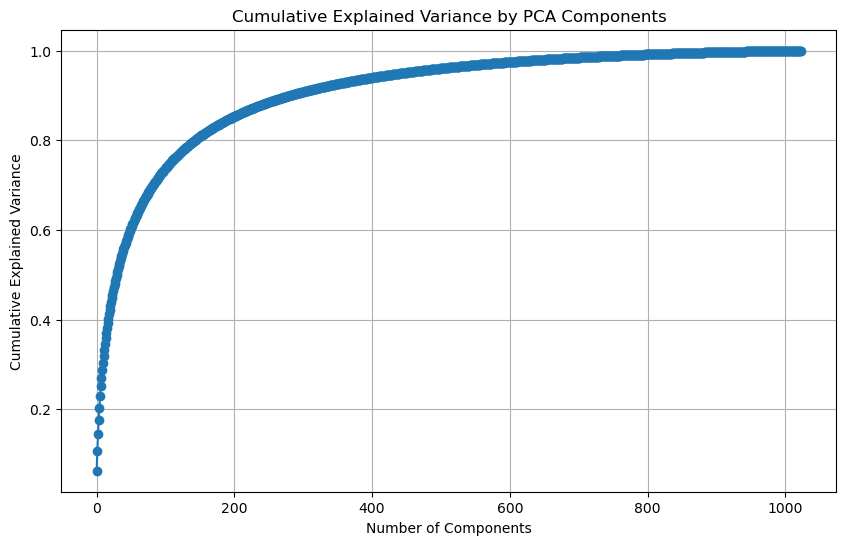

Number of components to retain 90% variance: 282
                                          embeddings  \
0  [0.0682, -0.04648, 0.001752, -0.00858, 0.00376...   
1  [-0.01643, -0.001583, 0.00389, 0.0734, 0.01243...   
2  [0.007904, 0.0877, -0.001715, 0.03766, 0.01788...   
3  [0.002447, 0.007053, 0.06445, 0.00727, -0.0335...   
4  [0.04932, 0.02069, 0.10864, 0.01634, -0.05106,...   

                                  reduced_embeddings  
0  [5.4523606599973125, -5.875826455560882, 0.083...  
1  [4.133830312377861, -1.0227187733458114, -7.10...  
2  [-4.523184760989732, -1.556923031001113, -3.69...  
3  [10.478726944890116, 1.9959073567759475, 9.146...  
4  [5.112677480156992, 5.149423233905597, 12.5065...  


In [36]:
# Extract embeddings and convert to NumPy array,
embeddings = np.array(combined_train['embeddings'].tolist())
# Standardize
scaler = StandardScaler()
embeddings_standardized = scaler.fit_transform(embeddings)

# Apply PCA\n",
pca = PCA()
pca.fit(embeddings_standardized)

# Plot cumulative explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Choose the number of components to retain (in our case 90% of variance)
n_components = np.argmax(np.cumsum(explained_variance) >= 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

# Apply PCA with chosen number of components
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings_standardized)

#Integrate reduced embeddings into combined_df
combined_train['reduced_embeddings'] = reduced_embeddings.tolist()
print(combined_train[['embeddings', 'reduced_embeddings']].head())

We'll see that considering each df separately doesn't change much.

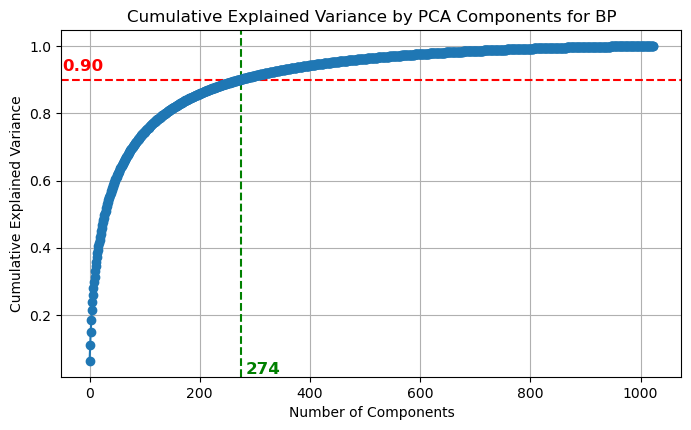

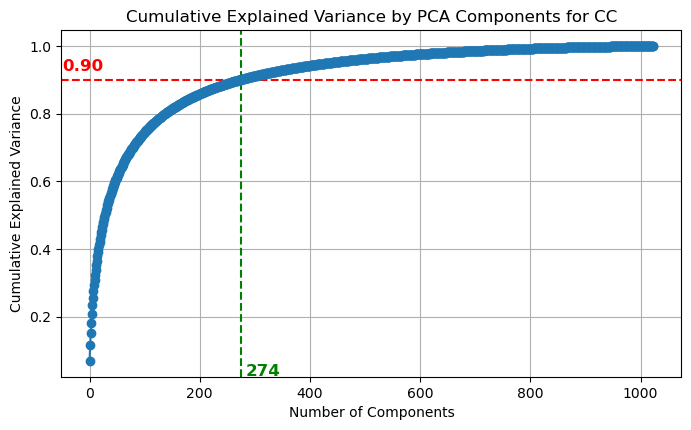

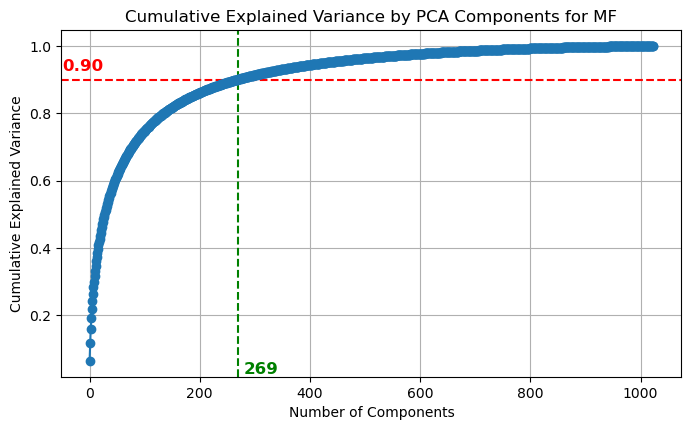

In [37]:
def pca_col(df, name, column_name='embeddings', variance_threshold=0.90):
    embeddings = np.array(df[column_name].tolist())
    
    scaler = StandardScaler()
    embeddings_standardized = scaler.fit_transform(embeddings)
    
    pca = PCA()
    pca.fit(embeddings_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Components to retain (in our case 90% of variance)
    n_components = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
        
    plt.figure(figsize=(8, 4.5))
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    x_value = np.argmax(np.cumsum(explained_variance) >= variance_threshold) + 1
    plt.axvline(x=x_value, color='g', linestyle='--')
    plt.text(x_value + 10, 0.025, f'{x_value}', color='green', size='large', weight='bold')
    plt.text(- 50, variance_threshold + 0.025, f'{variance_threshold:.2f}', color='red', size='large', weight='bold')

    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.title(f'Cumulative Explained Variance by PCA Components for {name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings_standardized)
    
    # Integrate reduced embeddings into the DataFrame
    df[f'reduced_{column_name}'] = reduced_embeddings.tolist()
    return df

# Apply PCA and add column for each dataset
x_df_BP = pca_col(x_df_BP, 'BP')
x_df_CC = pca_col(x_df_CC, 'CC')
x_df_MF = pca_col(x_df_MF, 'MF')

In [38]:
x_df_CC.columns.values

array(['ID', 'embeddings', 'sequence', 'ipr', 'domain', 'familyID',
       'start', 'end', 'reduced_embeddings'], dtype=object)

# MODELS

# CC (Elia)

In [39]:

import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Load data
X = x_df_CC['embeddings']  # Assuming embeddings are already reduced
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame

# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_CC)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Convert NumPy array to PyTorch tensor
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

## Models

In [42]:
# NN1

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [4096, 2048]    
output_size = y_train.shape[1]   

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
epochs = 75
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0406
Epoch [2/75], Loss: 0.0357
Epoch [3/75], Loss: 0.0330
Epoch [4/75], Loss: 0.0314
Epoch [5/75], Loss: 0.0299
Epoch [6/75], Loss: 0.0288
Epoch [7/75], Loss: 0.0263
Epoch [8/75], Loss: 0.0244
Epoch [9/75], Loss: 0.0229
Epoch [10/75], Loss: 0.0220
Epoch [11/75], Loss: 0.0208
Epoch [12/75], Loss: 0.0203
Epoch [13/75], Loss: 0.0192
Epoch [14/75], Loss: 0.0185
Epoch [15/75], Loss: 0.0179
Epoch [16/75], Loss: 0.0179
Epoch [17/75], Loss: 0.0171
Epoch [18/75], Loss: 0.0155
Epoch [19/75], Loss: 0.0156
Epoch [20/75], Loss: 0.0150
Epoch [21/75], Loss: 0.0150
Epoch [22/75], Loss: 0.0149
Epoch [23/75], Loss: 0.0131
Epoch [24/75], Loss: 0.0139
Epoch [25/75], Loss: 0.0140
Epoch [26/75], Loss: 0.0137
Epoch [27/75], Loss: 0.0126
Epoch [28/75], Loss: 0.0125
Epoch [29/75], Loss: 0.0118
Epoch [30/75], Loss: 0.0122
Epoch [31/75], Loss: 0.0121
Epoch [32/75], Loss: 0.0109
Epoch [33/75], Loss: 0.0128
Epoch [34/75], Loss: 0.0113
Epoch [35/75], Loss: 0.0102
Epoch [36/75], Loss: 0.0107
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# Print the model summary
_ = summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       4,198,400
              ReLU-2                 [-1, 4096]               0
           Dropout-3                 [-1, 4096]               0
            Linear-4                 [-1, 2048]       8,390,656
              ReLU-5                 [-1, 2048]               0
           Dropout-6                 [-1, 2048]               0
            Linear-7                  [-1, 678]       1,389,222
           Sigmoid-8                  [-1, 678]               0
Total params: 13,978,278
Trainable params: 13,978,278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 53.32
Estimated Total Size (MB): 53.48
----------------------------------------------------------------


In [44]:
# NN2
 
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.1),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [4096, 2048]          
output_size = y_train.shape[1]   

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0460
Epoch [2/75], Loss: 0.0420
Epoch [3/75], Loss: 0.0381
Epoch [4/75], Loss: 0.0364
Epoch [5/75], Loss: 0.0346
Epoch [6/75], Loss: 0.0330
Epoch [7/75], Loss: 0.0320
Epoch [8/75], Loss: 0.0308
Epoch [9/75], Loss: 0.0291
Epoch [10/75], Loss: 0.0281
Epoch [11/75], Loss: 0.0265
Epoch [12/75], Loss: 0.0252
Epoch [13/75], Loss: 0.0240
Epoch [14/75], Loss: 0.0230
Epoch [15/75], Loss: 0.0214
Epoch [16/75], Loss: 0.0202
Epoch [17/75], Loss: 0.0192
Epoch [18/75], Loss: 0.0181
Epoch [19/75], Loss: 0.0173
Epoch [20/75], Loss: 0.0160
Epoch [21/75], Loss: 0.0151
Epoch [22/75], Loss: 0.0146
Epoch [23/75], Loss: 0.0136
Epoch [24/75], Loss: 0.0130
Epoch [25/75], Loss: 0.0125
Epoch [26/75], Loss: 0.0119
Epoch [27/75], Loss: 0.0114
Epoch [28/75], Loss: 0.0110
Epoch [29/75], Loss: 0.0104
Epoch [30/75], Loss: 0.0097
Epoch [31/75], Loss: 0.0093
Epoch [32/75], Loss: 0.0092
Epoch [33/75], Loss: 0.0090
Epoch [34/75], Loss: 0.0087
Epoch [35/75], Loss: 0.0085
Epoch [36/75], Loss: 0.0084
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# NN3

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [2048, 1024]       
output_size = y_train.shape[1] 

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 2048

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0566
Epoch [2/75], Loss: 0.0465
Epoch [3/75], Loss: 0.0453
Epoch [4/75], Loss: 0.0431
Epoch [5/75], Loss: 0.0410
Epoch [6/75], Loss: 0.0395
Epoch [7/75], Loss: 0.0377
Epoch [8/75], Loss: 0.0368
Epoch [9/75], Loss: 0.0350
Epoch [10/75], Loss: 0.0346
Epoch [11/75], Loss: 0.0339
Epoch [12/75], Loss: 0.0329
Epoch [13/75], Loss: 0.0320
Epoch [14/75], Loss: 0.0311
Epoch [15/75], Loss: 0.0303
Epoch [16/75], Loss: 0.0297
Epoch [17/75], Loss: 0.0286
Epoch [18/75], Loss: 0.0282
Epoch [19/75], Loss: 0.0275
Epoch [20/75], Loss: 0.0265
Epoch [21/75], Loss: 0.0259
Epoch [22/75], Loss: 0.0255
Epoch [23/75], Loss: 0.0249
Epoch [24/75], Loss: 0.0237
Epoch [25/75], Loss: 0.0239
Epoch [26/75], Loss: 0.0233
Epoch [27/75], Loss: 0.0225
Epoch [28/75], Loss: 0.0218
Epoch [29/75], Loss: 0.0215
Epoch [30/75], Loss: 0.0206
Epoch [31/75], Loss: 0.0205
Epoch [32/75], Loss: 0.0200
Epoch [33/75], Loss: 0.0195
Epoch [34/75], Loss: 0.0190
Epoch [35/75], Loss: 0.0186
Epoch [36/75], Loss: 0.0180
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
# NN4

class ImprovedMultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ImprovedMultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),  # Batch Normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]
hidden_sizes = [2048, 1024]          
output_size = y_train.shape[1]  

# Initialize the model
model = ImprovedMultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function (Binary Cross-Entropy Loss)
criterion = nn.BCELoss()

# Optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
epochs = 75
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, scheduler, batch_size, epochs):
    model.train()

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, scheduler, batch_size, epochs)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)

# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nImproved Neural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))

Epoch [1/75], Loss: 4.2711
Epoch [2/75], Loss: 2.5187
Epoch [3/75], Loss: 2.3826
Epoch [4/75], Loss: 2.3427
Epoch [5/75], Loss: 2.3183
Epoch [6/75], Loss: 2.2319
Epoch [7/75], Loss: 2.2052
Epoch [8/75], Loss: 2.1826
Epoch [9/75], Loss: 2.1650
Epoch [10/75], Loss: 2.1526
Epoch [11/75], Loss: 2.0662
Epoch [12/75], Loss: 2.0287
Epoch [13/75], Loss: 2.0072
Epoch [14/75], Loss: 1.9864
Epoch [15/75], Loss: 1.9685
Epoch [16/75], Loss: 1.8845
Epoch [17/75], Loss: 1.8384
Epoch [18/75], Loss: 1.8079
Epoch [19/75], Loss: 1.7841
Epoch [20/75], Loss: 1.7581
Epoch [21/75], Loss: 1.6854
Epoch [22/75], Loss: 1.6424
Epoch [23/75], Loss: 1.6162
Epoch [24/75], Loss: 1.5894
Epoch [25/75], Loss: 1.5675
Epoch [26/75], Loss: 1.5125
Epoch [27/75], Loss: 1.4829
Epoch [28/75], Loss: 1.4630
Epoch [29/75], Loss: 1.4426
Epoch [30/75], Loss: 1.4260
Epoch [31/75], Loss: 1.3920
Epoch [32/75], Loss: 1.3712
Epoch [33/75], Loss: 1.3583
Epoch [34/75], Loss: 1.3460
Epoch [35/75], Loss: 1.3330
Epoch [36/75], Loss: 1.3117
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# NN5

class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2], output_size),
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1] 
hidden_sizes = [4096, 2048, 1024]    
output_size = y_train.shape[1]   

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
epochs = 75
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))

Epoch [1/75], Loss: 0.0458
Epoch [2/75], Loss: 0.0396
Epoch [3/75], Loss: 0.0358
Epoch [4/75], Loss: 0.0330
Epoch [5/75], Loss: 0.0316
Epoch [6/75], Loss: 0.0300
Epoch [7/75], Loss: 0.0276
Epoch [8/75], Loss: 0.0269
Epoch [9/75], Loss: 0.0258
Epoch [10/75], Loss: 0.0243
Epoch [11/75], Loss: 0.0237
Epoch [12/75], Loss: 0.0224
Epoch [13/75], Loss: 0.0225
Epoch [14/75], Loss: 0.0210
Epoch [15/75], Loss: 0.0208
Epoch [16/75], Loss: 0.0187
Epoch [17/75], Loss: 0.0183
Epoch [18/75], Loss: 0.0179
Epoch [19/75], Loss: 0.0172
Epoch [20/75], Loss: 0.0172
Epoch [21/75], Loss: 0.0170
Epoch [22/75], Loss: 0.0162
Epoch [23/75], Loss: 0.0164
Epoch [24/75], Loss: 0.0142
Epoch [25/75], Loss: 0.0138
Epoch [26/75], Loss: 0.0148
Epoch [27/75], Loss: 0.0139
Epoch [28/75], Loss: 0.0136
Epoch [29/75], Loss: 0.0130
Epoch [30/75], Loss: 0.0132
Epoch [31/75], Loss: 0.0142
Epoch [32/75], Loss: 0.0134
Epoch [33/75], Loss: 0.0132
Epoch [34/75], Loss: 0.0124
Epoch [35/75], Loss: 0.0124
Epoch [36/75], Loss: 0.0119
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparison of Neural Network Models

In this section, we compare the parameters and results of the five neural network models (NN 1, NN 2, NN 3, NN 4, and NN 5) used in our analysis.

### Model Parameters

| Model | Hidden Layer Sizes | Dropout Rates | Learning Rate | Batch Size | Epochs | Regularization |
|-------|---------------------|---------------|---------------|------------|--------|----------------|
| NN 1  | [4096, 2048]        | [0.3, 0.3]    | 0.005         | 512        | 75     | None           |
| NN 2  | [4096, 2048]        | [0.1, 0.1]    | 0.001         | 1024       | 75     | None           |
| NN 3  | [2048, 1024]        | [0.2, 0.2]    | 0.001         | 2048       | 75     | None           |
| NN 4  | [2048, 1024]        | [0.2, 0.3]    | 0.005         | 1024       | 75     | L2 (weight decay=1e-5) |
| NN 5  | [4096, 2048, 1024]  | [0.2, 0.2, 0.2]| 0.005         | 512        | 75     | None           |

### Model Results

| Model | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-Score | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg F1-Score | Samples Avg Precision | Samples Avg Recall | Samples Avg F1-Score | Training Time |
|-------|----------------------|------------------|---------------------|------------------------|---------------------|------------------------|-----------------------|---------------------|----------------------|---------------|
| NN 1  | 0.48                 | 0.34             | 0.38                | 0.72                   | 0.68                | 0.69                   | 0.78                  | 0.74                | 0.72                 | 70 min        |
| NN 2  | 0.54                 | 0.30             | 0.36                | 0.75                   | 0.63                | 0.67                   | 0.81                  | 0.70                | 0.71                 | 30 min        |
| NN 3  | 0.46                 | 0.17             | 0.22                | 0.74                   | 0.62                | 0.65                   | 0.82                  | 0.69                | 0.71                 | 10 min        |
| NN 4  | 0.41                 | 0.17             | 0.22                | 0.74                   | 0.64                | 0.67                   | 0.82                  | 0.71                | 0.72                 | 10 min        |
| NN 5  | 0.53                 | 0.27             | 0.33                | 0.74                   | 0.65                | 0.68                   | 0.80                  | 0.72                | 0.72                 | 90 min        |

### Observations

- **NN 1**: Achieved a balanced performance with a macro average F1-score of 0.38 and a weighted average F1-score of 0.69. The training time was the longest at 70 minutes.
- **NN 2**: Improved precision but lower recall compared to NN 1. The training time was reduced to 30 minutes.
- **NN 3**: Reduced hidden layer sizes and increased batch size resulted in a significant reduction in training time to 10 minutes, but the macro average F1-score dropped to 0.22.
- **NN 4**: Introduced batch normalization and L2 regularization. The performance was similar to NN 3, with a macro average F1-score of 0.22 and a weighted average F1-score of 0.67. The training time remained at 10 minutes.
- **NN 5**: Added an additional hidden layer and maintained dropout rates. Achieved a macro average F1-score of 0.33 and a weighted average F1-score of 0.68. The training time was 90 minutes.

Overall, **NN 1** provided the best balance between precision, recall, and F1-score, although it had the longest training time. **NN 2** offered a good trade-off between performance and training time. **NN 3** and **NN 4** had the shortest training times but lower macro average F1-scores. **NN 5** showed competitive performance with a slightly longer training time.

**Best result**: NN1
|   | Avg Precision | Avg Recall | Avg F1-Score |
|---|---|---|---|
| *Weighted*  | 0.72 | 0.68 | 0.69 |
| *Macro*  | 0.48 | 0.34 | 0.38 |

# MF (Vale)

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
# Load data
X = x_df_MF['embeddings']  # Assuming embeddings are already reduced
X = pd.DataFrame(X.tolist())  # Convert list of lists to DataFrame


# Preprocess target (MultiLabelBinarizer for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_df_MF)

# Split data
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:

np_array = X_train_full.to_numpy()
np_array_test = X_test_full.to_numpy()

# Convert NumPy array to PyTorch tensor
X_train_tensor = torch.tensor(np_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device) 
X_test_tensor = torch.tensor(np_array_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [51]:
# Define the Neural Network
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  # 300 features
hidden_sizes = [4096, 2048]    # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
batch_size = 512

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/50], Loss: 0.0425
Epoch [2/50], Loss: 0.0347
Epoch [3/50], Loss: 0.0315
Epoch [4/50], Loss: 0.0272
Epoch [5/50], Loss: 0.0235
Epoch [6/50], Loss: 0.0198
Epoch [7/50], Loss: 0.0171
Epoch [8/50], Loss: 0.0143
Epoch [9/50], Loss: 0.0117
Epoch [10/50], Loss: 0.0100
Epoch [11/50], Loss: 0.0093
Epoch [12/50], Loss: 0.0074
Epoch [13/50], Loss: 0.0068
Epoch [14/50], Loss: 0.0065
Epoch [15/50], Loss: 0.0053
Epoch [16/50], Loss: 0.0055
Epoch [17/50], Loss: 0.0047
Epoch [18/50], Loss: 0.0042
Epoch [19/50], Loss: 0.0041
Epoch [20/50], Loss: 0.0036
Epoch [21/50], Loss: 0.0038
Epoch [22/50], Loss: 0.0037
Epoch [23/50], Loss: 0.0029
Epoch [24/50], Loss: 0.0032
Epoch [25/50], Loss: 0.0029
Epoch [26/50], Loss: 0.0029
Epoch [27/50], Loss: 0.0024
Epoch [28/50], Loss: 0.0023
Epoch [29/50], Loss: 0.0022
Epoch [30/50], Loss: 0.0025
Epoch [31/50], Loss: 0.0022
Epoch [32/50], Loss: 0.0021
Epoch [33/50], Loss: 0.0020
Epoch [34/50], Loss: 0.0017
Epoch [35/50], Loss: 0.0021
Epoch [36/50], Loss: 0.0021
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# Define the Neural Network 2
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.1),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  # 300 features
hidden_sizes = [4096, 2048, 1024]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/100], Loss: 0.0429
Epoch [2/100], Loss: 0.0401
Epoch [3/100], Loss: 0.0373
Epoch [4/100], Loss: 0.0331
Epoch [5/100], Loss: 0.0307
Epoch [6/100], Loss: 0.0290
Epoch [7/100], Loss: 0.0276
Epoch [8/100], Loss: 0.0262
Epoch [9/100], Loss: 0.0255
Epoch [10/100], Loss: 0.0245
Epoch [11/100], Loss: 0.0238
Epoch [12/100], Loss: 0.0231
Epoch [13/100], Loss: 0.0223
Epoch [14/100], Loss: 0.0218
Epoch [15/100], Loss: 0.0211
Epoch [16/100], Loss: 0.0208
Epoch [17/100], Loss: 0.0203
Epoch [18/100], Loss: 0.0196
Epoch [19/100], Loss: 0.0192
Epoch [20/100], Loss: 0.0188
Epoch [21/100], Loss: 0.0182
Epoch [22/100], Loss: 0.0178
Epoch [23/100], Loss: 0.0172
Epoch [24/100], Loss: 0.0171
Epoch [25/100], Loss: 0.0166
Epoch [26/100], Loss: 0.0162
Epoch [27/100], Loss: 0.0158
Epoch [28/100], Loss: 0.0153
Epoch [29/100], Loss: 0.0150
Epoch [30/100], Loss: 0.0145
Epoch [31/100], Loss: 0.0143
Epoch [32/100], Loss: 0.0139
Epoch [33/100], Loss: 0.0135
Epoch [34/100], Loss: 0.0132
Epoch [35/100], Loss: 0

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Define the Neural Network pt 3
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  # 300 features
hidden_sizes = [2048, 1024, 512, 256]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 75
batch_size = 2048

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/75], Loss: 0.0815
Epoch [2/75], Loss: 0.0450
Epoch [3/75], Loss: 0.0415
Epoch [4/75], Loss: 0.0410
Epoch [5/75], Loss: 0.0402
Epoch [6/75], Loss: 0.0387
Epoch [7/75], Loss: 0.0370
Epoch [8/75], Loss: 0.0352
Epoch [9/75], Loss: 0.0337
Epoch [10/75], Loss: 0.0325
Epoch [11/75], Loss: 0.0313
Epoch [12/75], Loss: 0.0304
Epoch [13/75], Loss: 0.0297
Epoch [14/75], Loss: 0.0291
Epoch [15/75], Loss: 0.0286
Epoch [16/75], Loss: 0.0281
Epoch [17/75], Loss: 0.0275
Epoch [18/75], Loss: 0.0271
Epoch [19/75], Loss: 0.0266
Epoch [20/75], Loss: 0.0264
Epoch [21/75], Loss: 0.0259
Epoch [22/75], Loss: 0.0257
Epoch [23/75], Loss: 0.0253
Epoch [24/75], Loss: 0.0248
Epoch [25/75], Loss: 0.0248
Epoch [26/75], Loss: 0.0244
Epoch [27/75], Loss: 0.0242
Epoch [28/75], Loss: 0.0239
Epoch [29/75], Loss: 0.0237
Epoch [30/75], Loss: 0.0234
Epoch [31/75], Loss: 0.0232
Epoch [32/75], Loss: 0.0228
Epoch [33/75], Loss: 0.0226
Epoch [34/75], Loss: 0.0225
Epoch [35/75], Loss: 0.0223
Epoch [36/75], Loss: 0.0221
E

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
# Define the Neural Network 4
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [4096, 2048, 1024]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Training loop
epochs = 200
batch_size = 2048

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/200], Loss: 0.0460
Epoch [2/200], Loss: 0.0418
Epoch [3/200], Loss: 0.0410
Epoch [4/200], Loss: 0.0409
Epoch [5/200], Loss: 0.0408
Epoch [6/200], Loss: 0.0401
Epoch [7/200], Loss: 0.0382
Epoch [8/200], Loss: 0.0370
Epoch [9/200], Loss: 0.0361
Epoch [10/200], Loss: 0.0351
Epoch [11/200], Loss: 0.0334
Epoch [12/200], Loss: 0.0318
Epoch [13/200], Loss: 0.0303
Epoch [14/200], Loss: 0.0293
Epoch [15/200], Loss: 0.0284
Epoch [16/200], Loss: 0.0276
Epoch [17/200], Loss: 0.0267
Epoch [18/200], Loss: 0.0261
Epoch [19/200], Loss: 0.0256
Epoch [20/200], Loss: 0.0251
Epoch [21/200], Loss: 0.0247
Epoch [22/200], Loss: 0.0240
Epoch [23/200], Loss: 0.0236
Epoch [24/200], Loss: 0.0233
Epoch [25/200], Loss: 0.0229
Epoch [26/200], Loss: 0.0224
Epoch [27/200], Loss: 0.0221
Epoch [28/200], Loss: 0.0218
Epoch [29/200], Loss: 0.0213
Epoch [30/200], Loss: 0.0210
Epoch [31/200], Loss: 0.0205
Epoch [32/200], Loss: 0.0204
Epoch [33/200], Loss: 0.0200
Epoch [34/200], Loss: 0.0198
Epoch [35/200], Loss: 0

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
# Define the Neural Network 4
class MultilabelNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultilabelNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[2], output_size),
            nn.Sigmoid()  # For multilabel classification
        )
    
    def forward(self, x):
        return self.model(x)

# Define model parameters
input_size = X_train_tensor.shape[1]  
hidden_sizes = [8192, 4096, 2048]            # Hidden layer sizes
output_size = y_train.shape[1]    # Number of labels

# Initialize the model
model = MultilabelNN(input_size, hidden_sizes, output_size).to(device)

# Loss function and optimizer

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multilabel
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 150
batch_size = 1024

def train_model(model, X_train, y_train, optimizer, criterion, batch_size, epochs):
    # Determine the device (model should already be on this device)
    device = next(model.parameters()).device

    # Move training data to the device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the current batch
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Train the model
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, batch_size, epochs)

# Ensure X_test_tensor is on the same device as the model
device = next(model.parameters()).device
X_test_tensor = X_test_tensor.to(device)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Move predictions back to the CPU for further processing (e.g., NumPy conversion)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)


# Classification report
target_names = [str(cls) for cls in mlb.classes_]
print("\nNeural Network Results:")
print(classification_report(y_test, y_pred_binary, target_names=target_names))


Epoch [1/150], Loss: 0.0435
Epoch [2/150], Loss: 0.0416
Epoch [3/150], Loss: 0.0407
Epoch [4/150], Loss: 0.0388
Epoch [5/150], Loss: 0.0370
Epoch [6/150], Loss: 0.0352
Epoch [7/150], Loss: 0.0330
Epoch [8/150], Loss: 0.0313
Epoch [9/150], Loss: 0.0295
Epoch [10/150], Loss: 0.0283
Epoch [11/150], Loss: 0.0271
Epoch [12/150], Loss: 0.0264
Epoch [13/150], Loss: 0.0255
Epoch [14/150], Loss: 0.0245
Epoch [15/150], Loss: 0.0239
Epoch [16/150], Loss: 0.0232
Epoch [17/150], Loss: 0.0224
Epoch [18/150], Loss: 0.0216
Epoch [19/150], Loss: 0.0209
Epoch [20/150], Loss: 0.0204
Epoch [21/150], Loss: 0.0196
Epoch [22/150], Loss: 0.0193
Epoch [23/150], Loss: 0.0186
Epoch [24/150], Loss: 0.0179
Epoch [25/150], Loss: 0.0174
Epoch [26/150], Loss: 0.0169
Epoch [27/150], Loss: 0.0164
Epoch [28/150], Loss: 0.0159
Epoch [29/150], Loss: 0.0155
Epoch [30/150], Loss: 0.0155
Epoch [31/150], Loss: 0.0146
Epoch [32/150], Loss: 0.0146
Epoch [33/150], Loss: 0.0142
Epoch [34/150], Loss: 0.0138
Epoch [35/150], Loss: 0

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
#TRIED TO DO CNN BUT SUCKS MORE GPU THAN A WHORE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Move tensors to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

# Define sequence length
sequence_length = 10  
input_size = X_train_tensor.shape[1]  
output_size = y_train_tensor.shape[1]  

# Ensure number of samples is divisible by sequence length
num_samples = (X_train_tensor.shape[0] // sequence_length) * sequence_length
X_train_seq = X_train_tensor[:num_samples].view(-1, 1, sequence_length, input_size)  # CNN expects 4D input

# Fix label mismatch
y_train_seq = y_train_tensor[:num_samples].view(-1, sequence_length, output_size)[:, -1, :]

# Verify shapes
print(f"X_train_seq shape: {X_train_seq.shape}")  # Expected: (batch, 1, 10, 1024)
print(f"y_train_seq shape: {y_train_seq.shape}")  # Expected: (batch, 678)

# Create DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_seq, y_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        # Forward pass a dummy tensor to calculate output shape
        dummy_input = torch.zeros(1, 1, sequence_length, input_size)
        with torch.no_grad():
            dummy_output = self.pool(self.conv1(dummy_input))
            dummy_output = self.pool(self.conv2(dummy_output))
            dummy_output = self.pool(self.conv3(dummy_output))
        
        # Get the flattened size dynamically
        self.flatten_size = dummy_output.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.fc2 = nn.Linear(1024, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))

        x = x.view(x.shape[0], -1)  # Flatten dynamically
        x = nn.ReLU()(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


# Initialize model, loss, and optimizer
model = CNNModel(input_channels=1, output_size=output_size).to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        
        # Ensure output and target shapes match
        if outputs.shape != y_batch.shape:
            print(f"Skipping batch due to shape mismatch: {outputs.shape} vs {y_batch.shape}")
            continue

        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    num_test_samples = (X_test_tensor.shape[0] // sequence_length) * sequence_length
    X_test_seq = X_test_tensor[:num_test_samples].view(-1, 1, sequence_length, input_size).to(device)

    y_pred = model(X_test_seq)

    # Convert predictions to binary (threshold = 0.5)
    y_pred_binary = (y_pred.cpu().numpy() > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
target_names = [str(cls) for cls in mlb.classes_]
print("\nCNN Model Results:")
print(classification_report(y_test[:len(y_pred_binary)], y_pred_binary, target_names=target_names))


X_train_seq shape: torch.Size([4455, 1, 10, 1024])
y_train_seq shape: torch.Size([4455, 839])
Epoch [1/20], Loss: 0.2309
Epoch [2/20], Loss: 0.0636
Epoch [3/20], Loss: 0.0448
Epoch [4/20], Loss: 0.0435
Epoch [5/20], Loss: 0.0425
Epoch [6/20], Loss: 0.0421
Epoch [7/20], Loss: 0.0421
Epoch [8/20], Loss: 0.0421
Epoch [9/20], Loss: 0.0420
Epoch [10/20], Loss: 0.0420
Epoch [11/20], Loss: 0.0420
Epoch [12/20], Loss: 0.0420
Epoch [13/20], Loss: 0.0420
Epoch [14/20], Loss: 0.0420
Epoch [15/20], Loss: 0.0421
Epoch [16/20], Loss: 0.0421
Epoch [17/20], Loss: 0.0420
Epoch [18/20], Loss: 0.0421
Epoch [19/20], Loss: 0.0420
Epoch [20/20], Loss: 0.0421

CNN Model Results:
              precision    recall  f1-score   support

  GO:0000030       0.00      0.00      0.00         4
  GO:0000049       0.00      0.00      0.00         3
  GO:0000146       0.00      0.00      0.00         0
  GO:0000149       0.00      0.00      0.00         1
  GO:0000166       0.00      0.00      0.00        36
  GO:00001

c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vale\miniconda3\envs\torch\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


E FA ANCHE CAGARE